## Binary Classification with XGBoost

xgboost tbd.

In [14]:
# load packages
import os
import numpy as np
import pandas as pd
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, precision_score, f1_score
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

In [3]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# load lagged dataset
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [60]:
df.drop(['wind_speed_m/s', 'wind_speed_m/s_lag1', 'wind_speed_m/s_lag2', 'wind_speed_m/s_lag3'], inplace = True, axis=1)

In [61]:
# get desired df size
start_date = '2021-07-01'
end_date = '2023-11-30'
df_cv = df.loc[start_date:end_date]

In [55]:
# impute, scale pipeline and smote (for class imbalance)
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# define features X and target y
X = df_cv.drop(['redispatch', 'level'], axis = 1)
y = df_cv['redispatch']

In [56]:
share_minority = y.value_counts().get(1, 0)/len(y)
print(share_minority)

0.12164339419978518


In [8]:
# importance of the last redispatch status for the training data
def last_redispatch(y_train, window_size=2): #2h in advance
    """
    Computes the importance of the last redispatch status for each data point in the training data
    using a rolling window. It creates a list by summing the redispatch statuses of the
    last values within the defined window. (LAST SENTENCE TO BE CHANGED)
    """
    last_redispatch_importance = []
    for i in range(len(y_train)):
        window_start = max(0, i - window_size)
        window_end = i
        importance = y_train.iloc[window_start:window_end].sum()/window_size
        last_redispatch_importance.append(importance)

    return last_redispatch_importance

**K-fold cross-validation**\
tbd.

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Training on valid fold 1
Fold 9
Fold 10
Training on valid fold 2
Fold 11
Training on valid fold 3
Fold 12
Fold 13
Fold 14
Training on valid fold 4
Fold 15
Fold 16
Fold 17
Fold 18
Fold 19
Fold 20
Fold 21
Fold 22
Fold 23
Fold 24
Fold 25
Fold 26
Fold 27
Fold 28
Fold 29
Fold 30
Fold 31
Fold 32
Fold 33
Fold 34
Fold 35
Fold 36
Training on valid fold 5
Fold 37
Fold 38
Fold 39
Training on valid fold 6
Fold 40
Fold 41
Fold 42
Fold 43
Fold 44
Fold 45
Fold 46
Fold 47
Fold 48
Fold 49
Fold 50
Fold 51
Fold 52
Fold 53
Fold 54
Fold 55
Fold 56
Fold 57
Fold 58
Fold 59
Fold 60
Fold 61
Fold 62
Training on valid fold 7
Fold 63
Fold 64
Fold 65
Fold 66
Fold 67
Fold 68
Fold 69
Fold 70
Fold 71
Fold 72
Fold 73
Fold 74
Fold 75
Fold 76
Fold 77
Fold 78
Fold 79
Fold 80
Fold 81
Fold 82
Fold 83
Training on valid fold 8
Fold 84
Fold 85
Training on valid fold 9
Fold 86
Fold 87
Fold 88
Fold 89
Fold 90
Fold 91
Fold 92
Fold 93
Fold 94
Fold 95
Fold 96
Fold 97
Fold 98


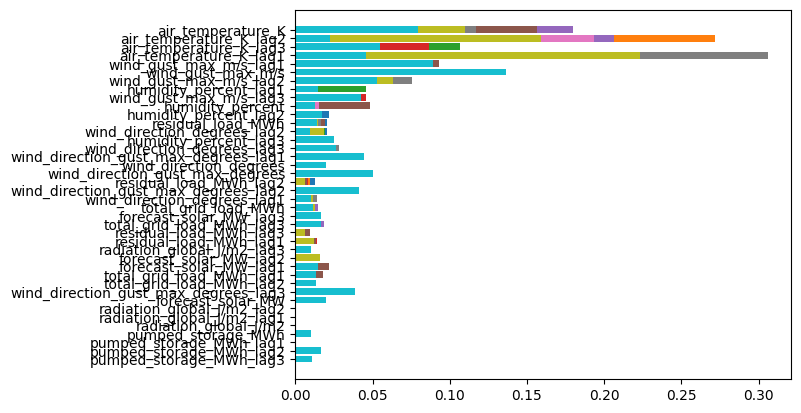

In [62]:
# create model instance
xgboost_class = XGBClassifier(booster='gbtree', reg_alpha=5, reg_lambda=5, eval_metric='logloss', scale_pos_weight=2,
                              n_estimators=300, max_depth=1, learning_rate=0.1, objective='binary:logistic', random_state = 13)

# cross-validation
n_splits = 500 #stops at 10 valid folds
test_size = 96 #(24 - 6h; 48 - 12h; 96 - 24h with 15 min intervalls)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

precision_scores = []
f1_scores = []
conf_matrices = []
precision_train_scores = []
f1_train_scores = []
conf_train_matrices = []

total_folds = 0
valid_folds = 0
for train_index, test_index in tscv.split(X):
    total_folds += 1
    print(f"Fold {total_folds}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Check if stratification condition is met and fold is within the first 10
    if abs(y_test.sum()/len(y_test) - share_minority) < 0.05:
      valid_folds += 1  # Increment the valid folds counter
      print(f"Training on valid fold {valid_folds}")
      '''
      ####
      # add importance of the last redispatch status for train
      last_redispatch_importance_train = last_redispatch(y_train_preprocessed)
      X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
      X_train_preprocessed['last_redispatch_importance'] = last_redispatch_importance_train
      ####
      '''
      # preprocess train data
      X_train_scaled = preprocessor.fit_transform(X_train)
      X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_scaled, y_train)

      # fit model
      #sample_weights = np.linspace(0, 2, len(y_train_preprocessed))  # linearly increasing weights
      #sample_weights = np.where(y_train_preprocessed == 0, 1, 2)
      xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)#, sample_weight=sample_weights)

      # preprocess test data
      X_test_preprocessed = preprocessor.transform(X_test)

      '''
      ######
      X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)
      X_test_preprocessed_df['last_redispatch_importance'] = 0
      y_pred_proba = np.zeros(len(X_test))
      y_pred = np.zeros(len(X_test))

      window = 2
      for i in range(len(X_test)):
          if i == 0:
              last_redispatch_importance = y_train.iloc[-2:].sum() / window
          elif i == 1:
              last_redispatch_importance = (y_train.iloc[-1:].sum() + y_pred[i - 1]) / window
          else:
              last_redispatch_importance = (y_pred[i - 2] + y_pred[i - 1]) / window
          X_test_preprocessed_df.loc[i, 'last_redispatch_importance'] = last_redispatch_importance
          #y_pred[i] = xgboost_class.predict(X_test_preprocessed_df.iloc[[i]].values.reshape(1, -1))[0]
          y_pred_proba[i] = xgboost_class.predict_proba(X_test_preprocessed_df.iloc[[i]].values.reshape(1, -1))[:, 1]
          y_pred[i] = (y_pred_proba[i] >= threshold).astype(int)
      #####
      '''

      # with threshold for prediction
      threshold = 0.75
      y_pred_proba = xgboost_class.predict_proba(X_test_preprocessed)[:, 1]
      y_pred = (y_pred_proba >= threshold).astype(int)
      y_train_proba = xgboost_class.predict_proba(X_train_preprocessed)[:, 1]
      y_pred_train = (y_train_proba >= threshold).astype(int)

      # evaluate
      precision_scores.append(precision_score(y_test, y_pred))
      f1_scores.append(f1_score(y_test, y_pred))
      conf_matrices.append(confusion_matrix(y_test, y_pred))
      precision_train_scores.append(precision_score(y_train_preprocessed, y_pred_train))
      f1_train_scores.append(f1_score(y_train_preprocessed, y_pred_train))
      conf_train_matrices.append(confusion_matrix(y_train_preprocessed, y_pred_train))

      sorted_idx = xgboost_class.feature_importances_.argsort()
      plt.barh(X_test.columns[sorted_idx], xgboost_class.feature_importances_[sorted_idx])

      if valid_folds == 10:
        break

# print evaluation
print("Average Scores:")
print("Precision:", np.array(precision_scores).mean())
print("F1-Scores:", np.array(f1_scores).mean())
average_conf_matrix = np.round(sum(conf_matrices) / len(conf_matrices)).astype(int)
print("Average Confusion Matrix:")
print(f"{'True Negative':<20} {'False Positive':<20}")
print(f"{average_conf_matrix[0][0]:<20} {average_conf_matrix[0][1]:<20}")
print(f"{'False Negative':<20} {'True Positive':<20}")
print(f"{average_conf_matrix[1][0]:<20} {average_conf_matrix[1][1]:<20}")

print("Precision (Train):", np.array(precision_train_scores).mean())
print("F1-Scores (Train):", np.array(f1_train_scores).mean())
average_conf_matrix_train = np.round(sum(conf_train_matrices) / len(conf_train_matrices)).astype(int)
print("Average Confusion Matrix (Train):")
print(f"{'True Negative':<20} {'False Positive':<20}")
print(f"{average_conf_matrix_train[0][0]:<20} {average_conf_matrix_train[0][1]:<20}")
print(f"{'False Negative':<20} {'True Positive':<20}")
print(f"{average_conf_matrix_train[1][0]:<20} {average_conf_matrix_train[1][1]:<20}")

In [ ]:
# SHAP values for model interpretability

**Train model with best hyperparameters and safe**

In [63]:
# select train datset
start_date = '2021-07-01'
end_date = '2023-11-30'
df_model_train = df.loc[start_date:end_date]
df_model_pred = df.loc['2023-11-30':'2023-12-31']

# define features X and target y
X_train = df_model_train.drop(['redispatch', 'level'], axis = 1)
X_test = df_model_pred.drop(['redispatch', 'level'], axis = 1)
y_train = df_model_train['redispatch']
y_test = df_model_pred['redispatch']

# preprocess train and test data
X_train_scaled = preprocessor.fit_transform(X_train)
X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_scaled, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

# fit model
xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=13, ...)

In [64]:
# safe XGBoost classifier
joblib.dump(xgboost_class, '/content/drive/My Drive/ms_wind_curtailment_prediction/xgboost_class.pkl')

['/content/drive/My Drive/ms_wind_curtailment_prediction/xgboost_class.pkl']

**Grid Search CV**

• it is doing its own train/test split\
• the last feature importance is calculated for every timestamp. to not get wrong results it is shifted by 48 (12h)


In [ ]:
# importance of the last redispatch status for the training data
window_size = 4  #last 60 min
last_redispatch_importance = []
for i in range(len(df)):
    window_start = max(0, i - window_size)
    window_end = i
    importance = df['redispatch'].iloc[window_start:window_end].sum() #also incorporate the level ???
    last_redispatch_importance.append(importance)

df['last_redispatch_importance'] = last_redispatch_importance
df['last_redispatch_importance'] = df['last_redispatch_importance'].shift(48)
df.dropna(inplace = True)

X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

In [ ]:
# preprocess data
X_scaled = preprocessor.fit_transform(X)
X_preprocessed, y_preprocessed = smote.fit_resample(X_scaled, y)

# parameter grid
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5]
}

# timeseries split
test_size = 48
tscv = TimeSeriesSplit(test_size=test_size)

# XGBClassifier and GridSearchCV
xgboost_class = XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic', random_state=13)
grid_search = GridSearchCV(estimator=xgboost_class, param_grid=param_grid, cv=tscv, scoring='precision', n_jobs=-1)

# fit
grid_search.fit(X_scaled, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

KeyboardInterrupt: 

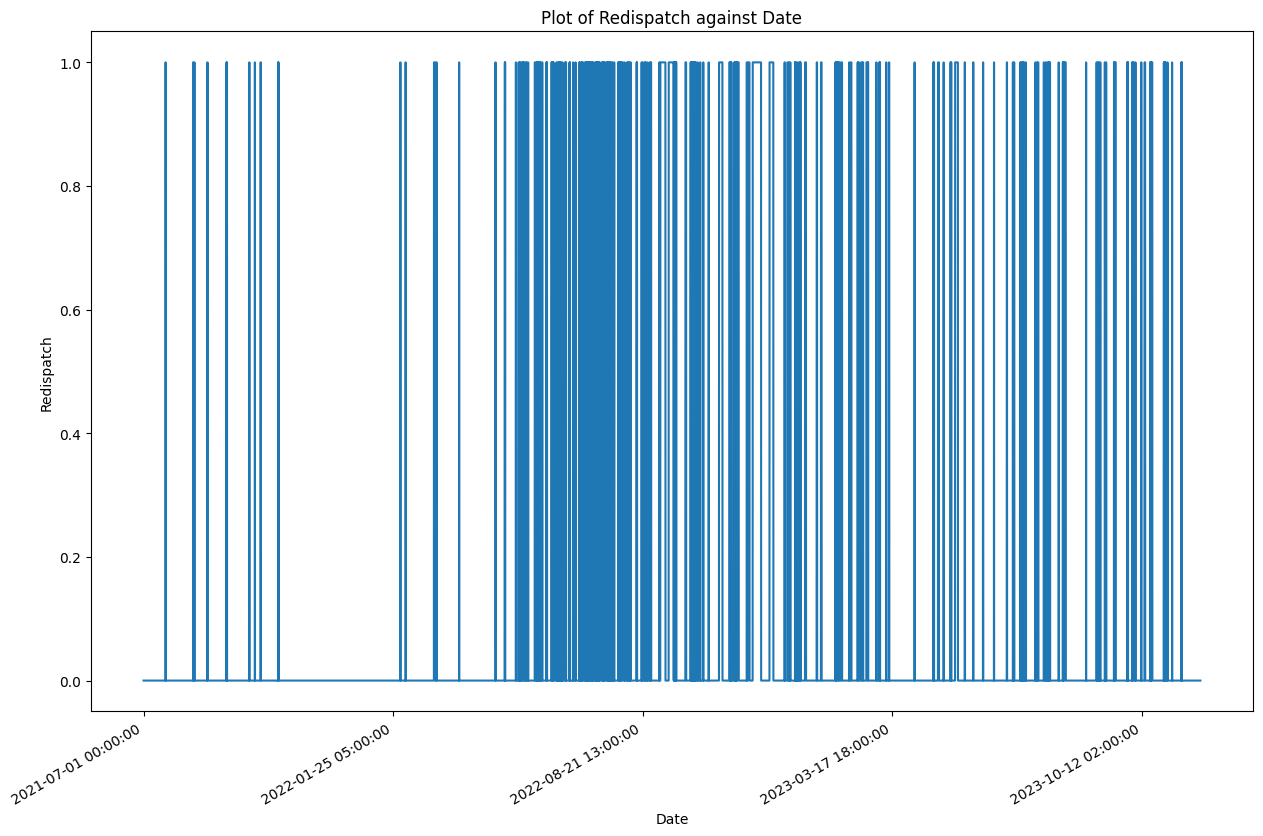

In [53]:
# plot redispatch against the datetime index
start_date = '2021-07-01'
end_date = '2023-11-30'
ax = df.loc[start_date:end_date, 'redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format and limits
plt.gcf().autofmt_xdate()

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch against Date')

# Show the plot
plt.show()